## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/*.jpg')
img_size = (720, 1280)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img_size = gray.shape

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [3]:
def correct_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

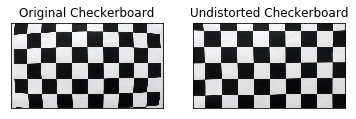

In [17]:
img = cv2.imread(images[0])    
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corrected = correct_image(img)

fig = plt.figure()
plt.subplot(121),
plt.imshow(img, cmap = 'gray')
plt.title('Original Checkerboard'),
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(corrected, cmap = 'gray')
plt.title('Undistorted Checkerboard'), 
plt.xticks([]), plt.yticks([])
plt.show()
#fig.savefig('undistort_checkerboard.png', dpi=fig.dpi)


In [233]:
def make_paralel(img):
    img_width, img_height = (img.shape[1], img.shape[0])
    #bottom_width = 0.76
    #top_width = 0.85
    #height = 0.62
    #top_width = 0.0245
    #height = 0.7
    bottom_width = 0.105
    top_width = 0.0148
    height = 0.63
    bottom_trim = 55
    src = np.float32([
    [img_width * (0.5 - top_width/2), img_height * height], 
    [img_width * (0.5 + top_width/2), img_height * height], 
    [img_width * (0.5 + bottom_width/2), img_height - bottom_trim ], 
    [img_width * (0.5 - bottom_width/2), img_height - bottom_trim ]])
    offset = img_width * 0.46
    dst = np.float32([
        [offset, 0],
        [img_width - offset, 0],
        [img_width - offset, img_height],
        [offset, img_height ]
        ]) 
    M = cv2.getPerspectiveTransform(src, dst)
    #print(img.shape[1::-1])
    warped = cv2.warpPerspective(img, M,  (int(img_width), img_height))
    return warped

In [234]:
def preprocess_image(img, s_thresh=(80, 255), sx_thresh=(20, 100), sy_thresh=(200, 205)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=31) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=5) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(scaled_sobel)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    dst = cv2.undistort(combined_binary, mtx, dist, None, mtx)
    return dst    

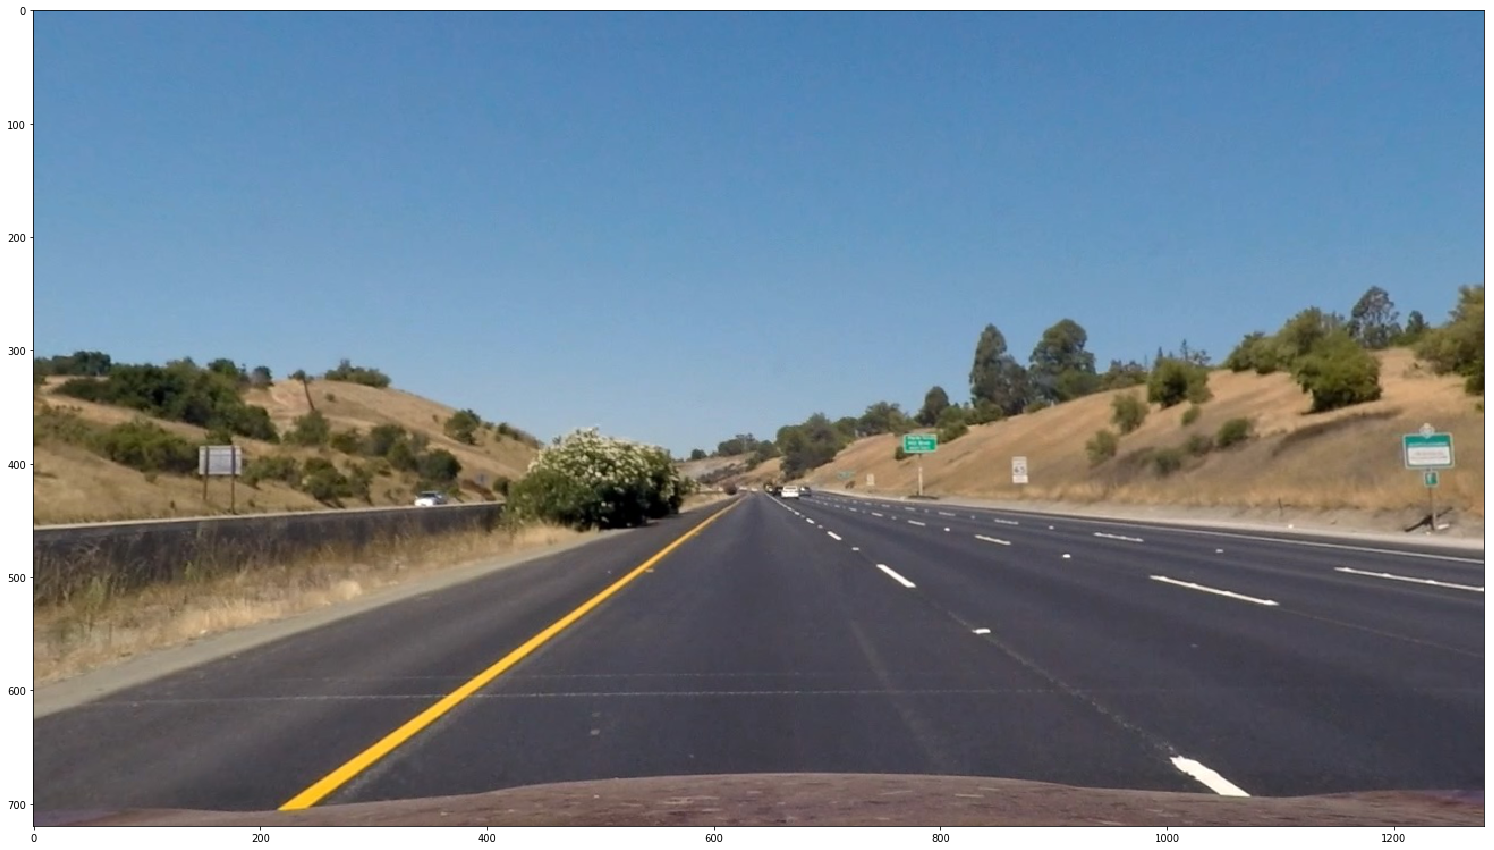

In [18]:
#img = cv2.medianBlur(cv2.cvtColor(cv2.imread('dump/1491015021.292393.jpg'), cv2.COLOR_BGR2RGB), 3 )

#the bright patch
#img = cv2.cvtColor(cv2.imread('dump/1491015021.292393.jpg'), cv2.COLOR_BGR2RGB)

#regullar road
img = correct_image(cv2.cvtColor(cv2.imread('../test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB))
#img = cv2.cvtColor(cv2.imread('../test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(img)
plt.show()
#fig.savefig('corrected_image.png', dpi=fig.dpi)

#b,g,r = cv2.split(img)
#clahe = cv2.createCLAHE(clipLimit=3.9, tileGridSize=(33,33))
#bc = clahe.apply(b)
#gc = clahe.apply(g)
#rc = clahe.apply(r)
#cl1 = cv2.merge((bc,gc,rc))

#fig = plt.figure(figsize=(26, 16)) 
#plt.imshow(cl1)
#plt.show()

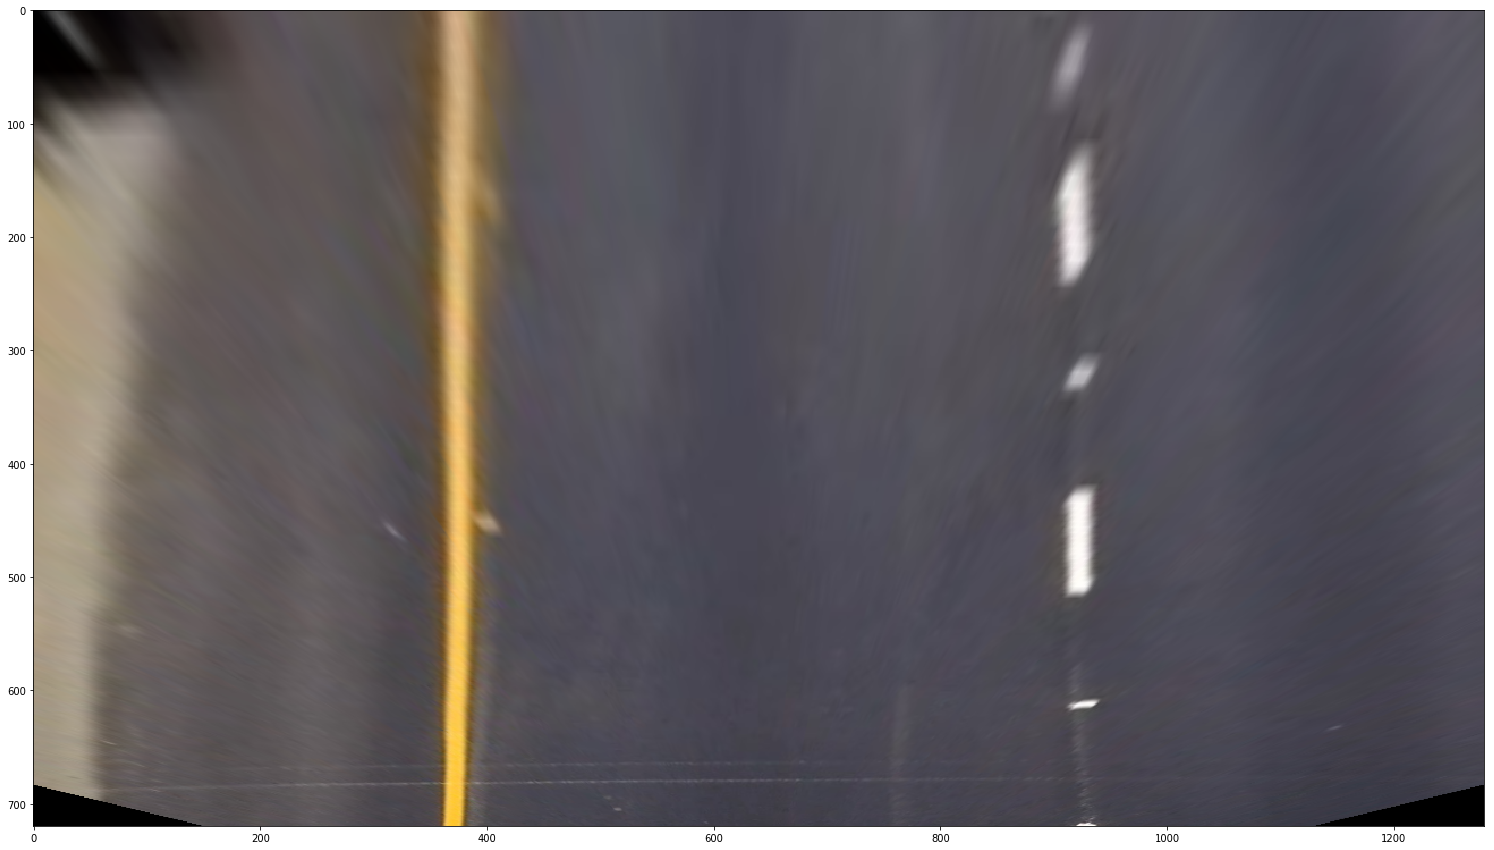

In [236]:
parallel = make_paralel(img)

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(parallel, cmap='gray')
plt.show()

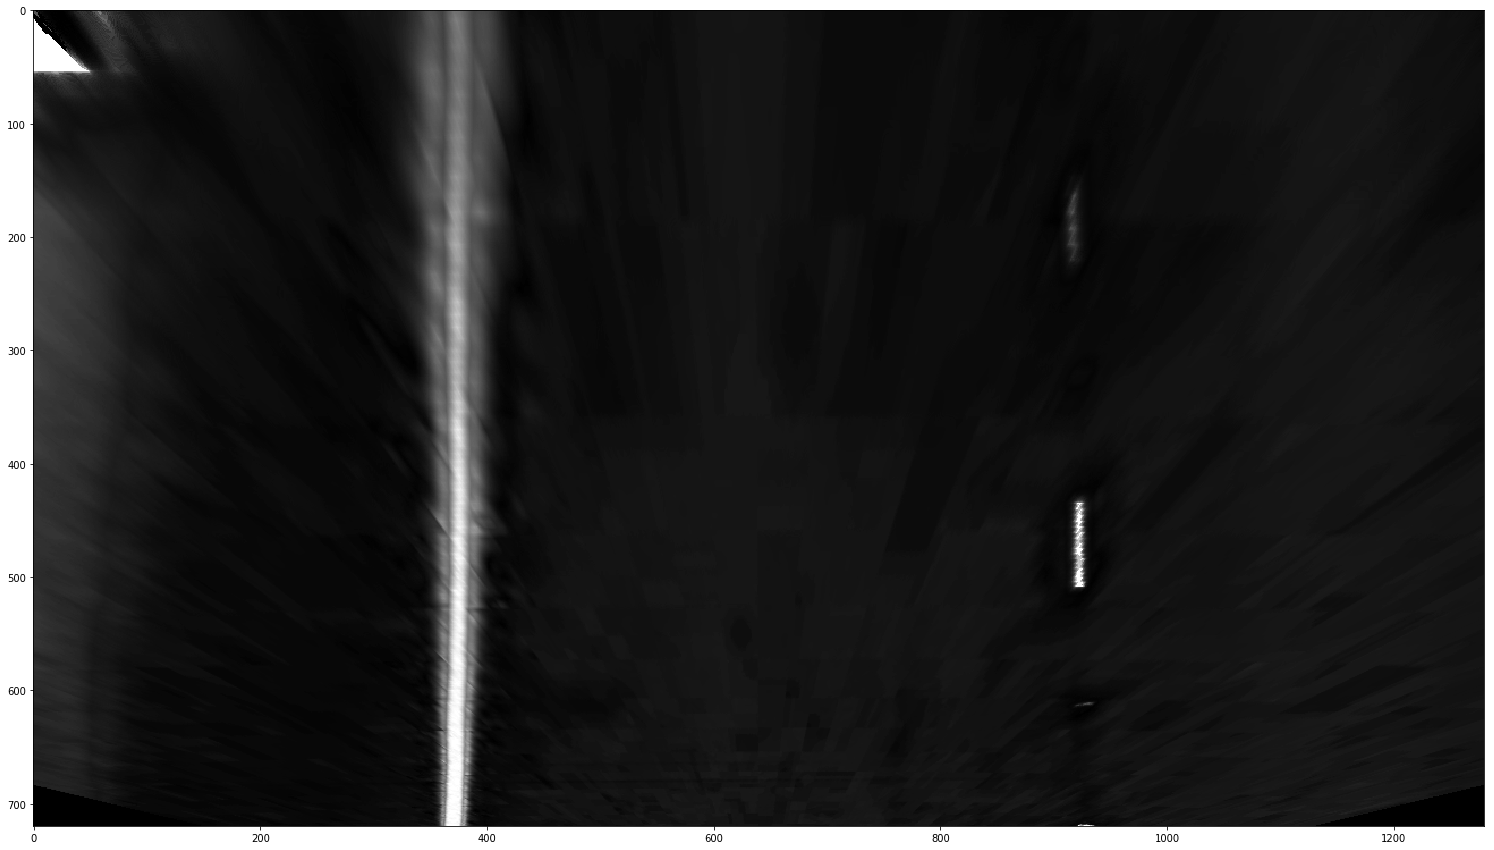

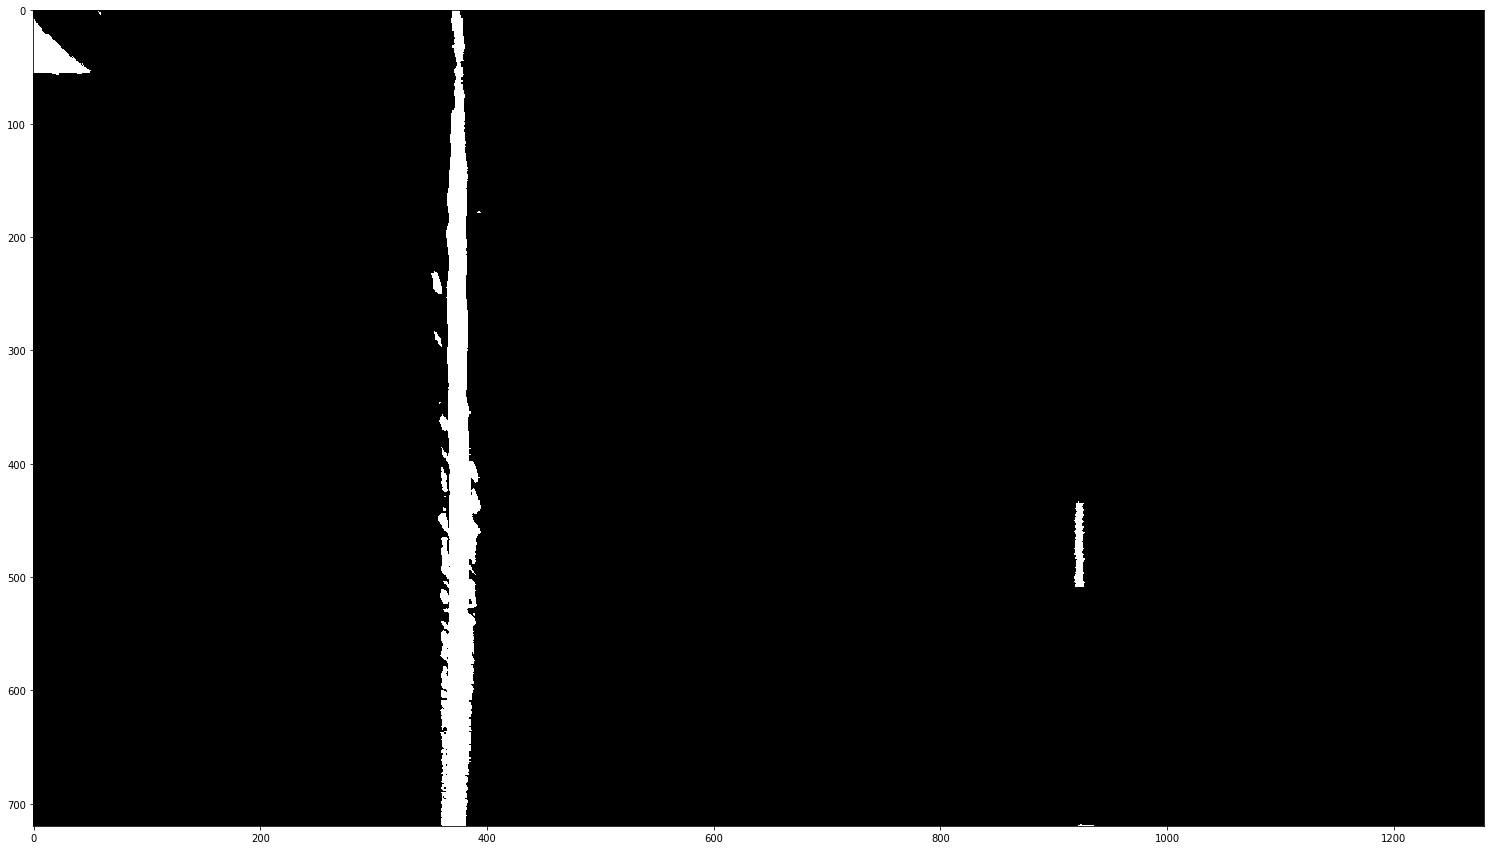

In [237]:
hsv = cv2.cvtColor(parallel, cv2.COLOR_RGB2HLS)

l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(s_channel, cmap='gray')
plt.show()

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 110) & (s_channel <= 255)] = 1

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(s_binary, cmap='gray')
plt.show()


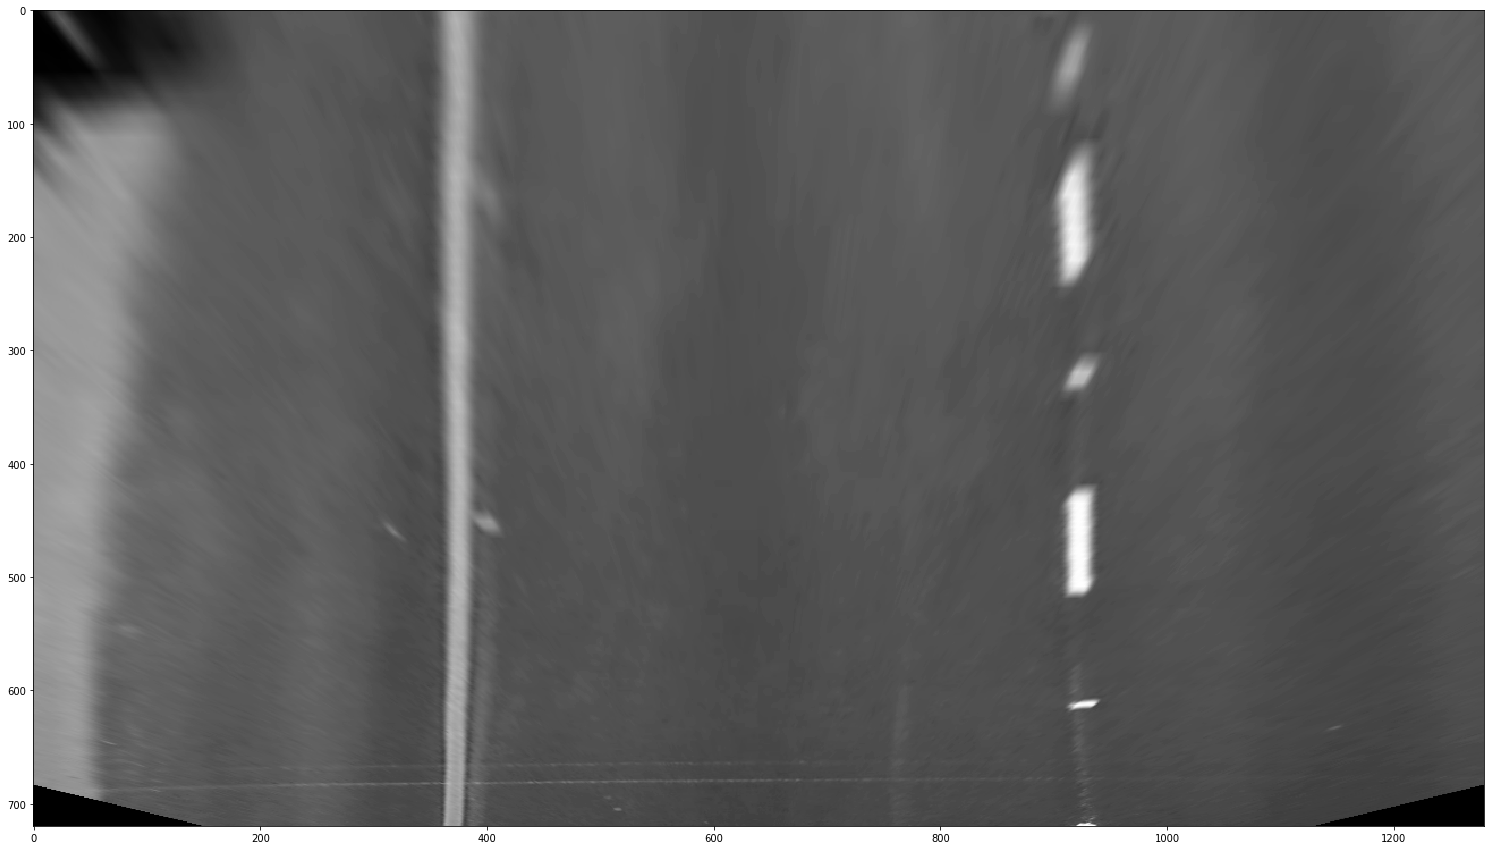

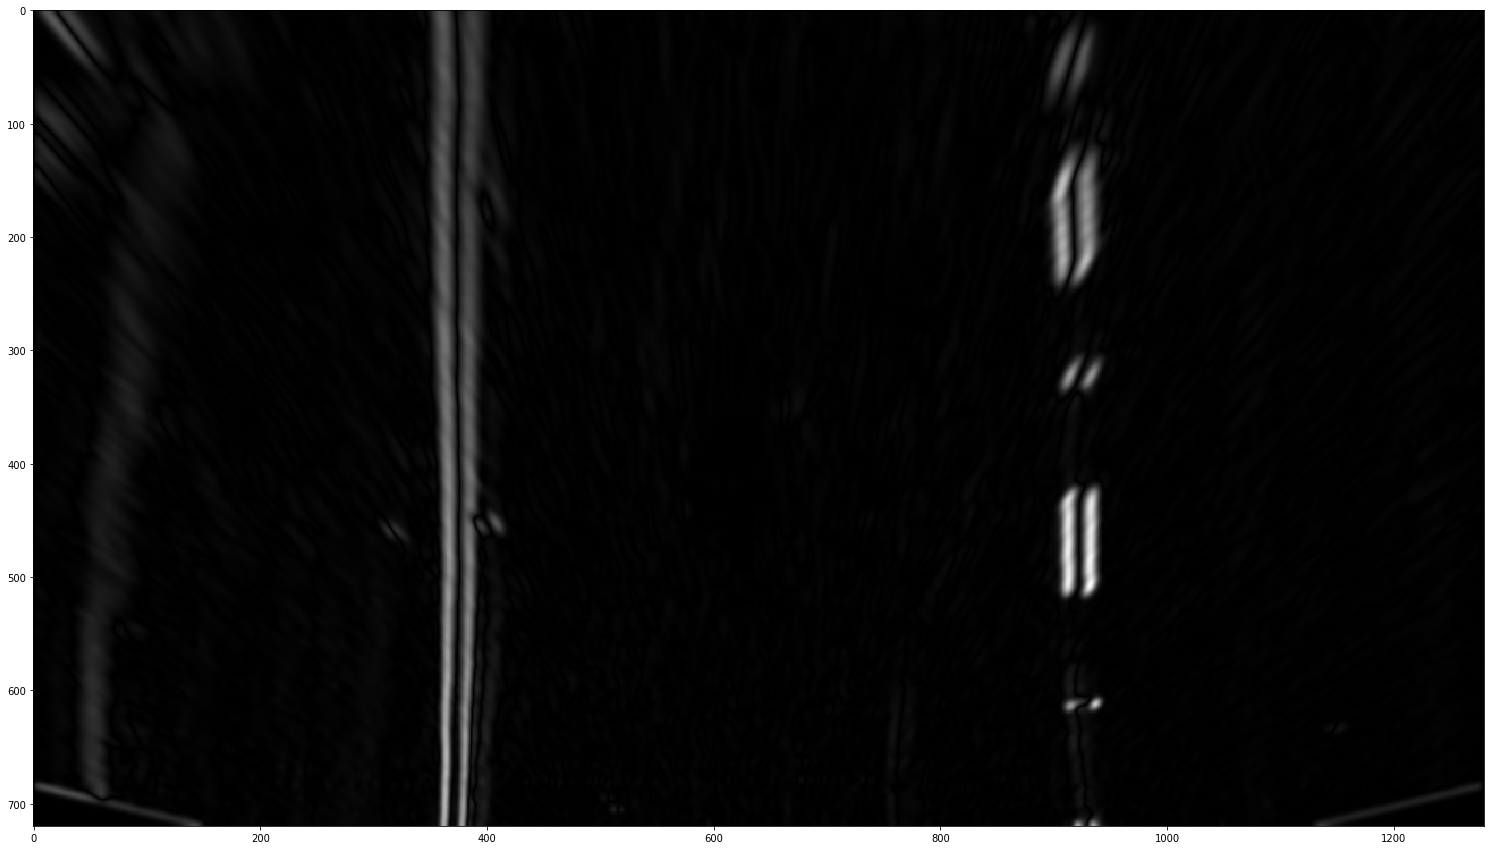

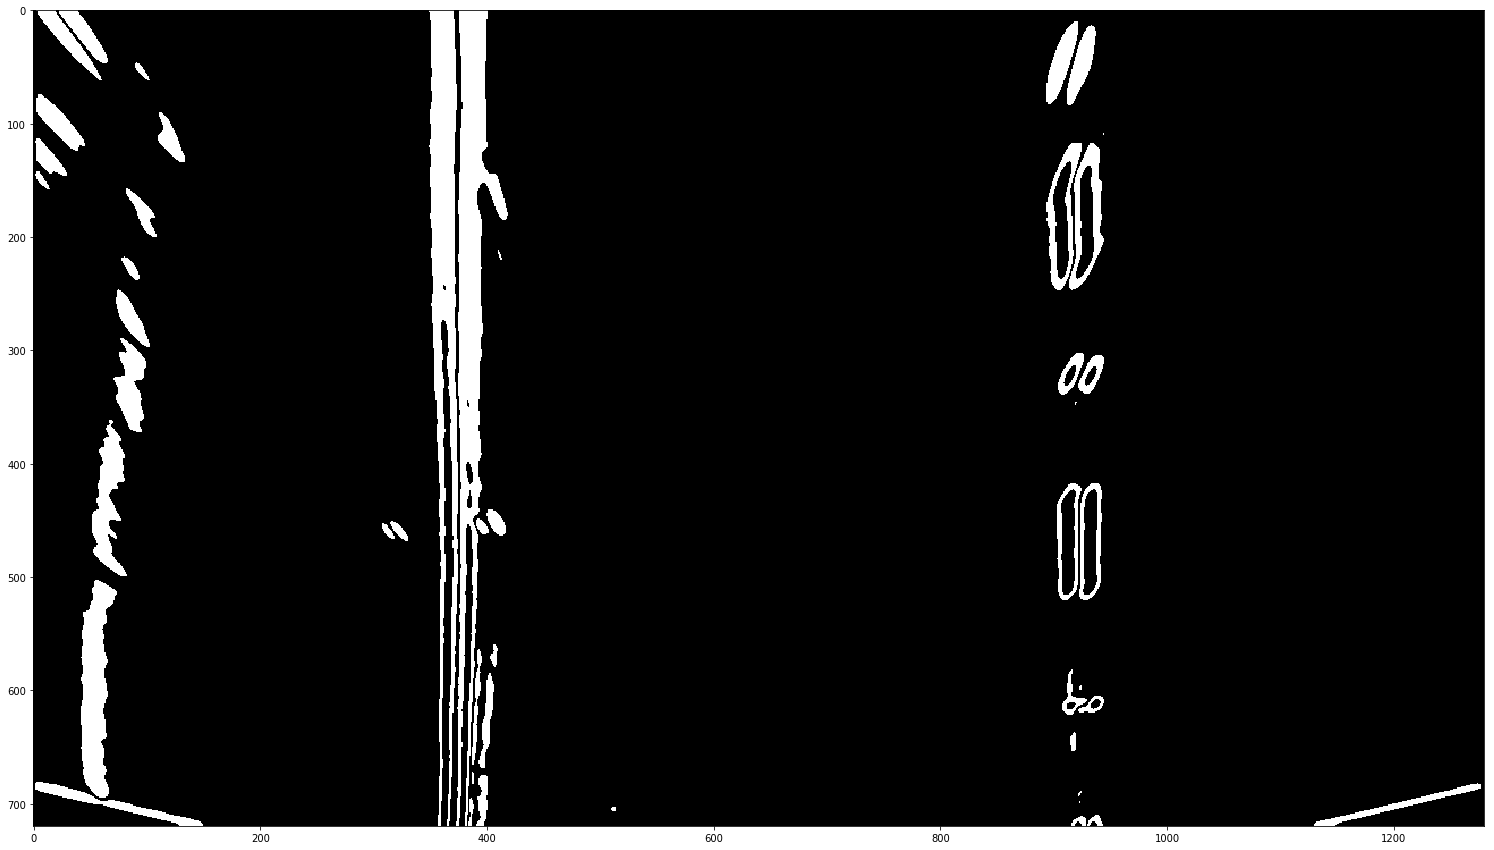

In [238]:
fig = plt.figure(figsize=(26, 16)) 
plt.imshow(l_channel, cmap='gray')
plt.show()

sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=31) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(scaled_sobel, cmap='gray')
plt.show()

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(sxbinary, cmap='gray')
plt.show()


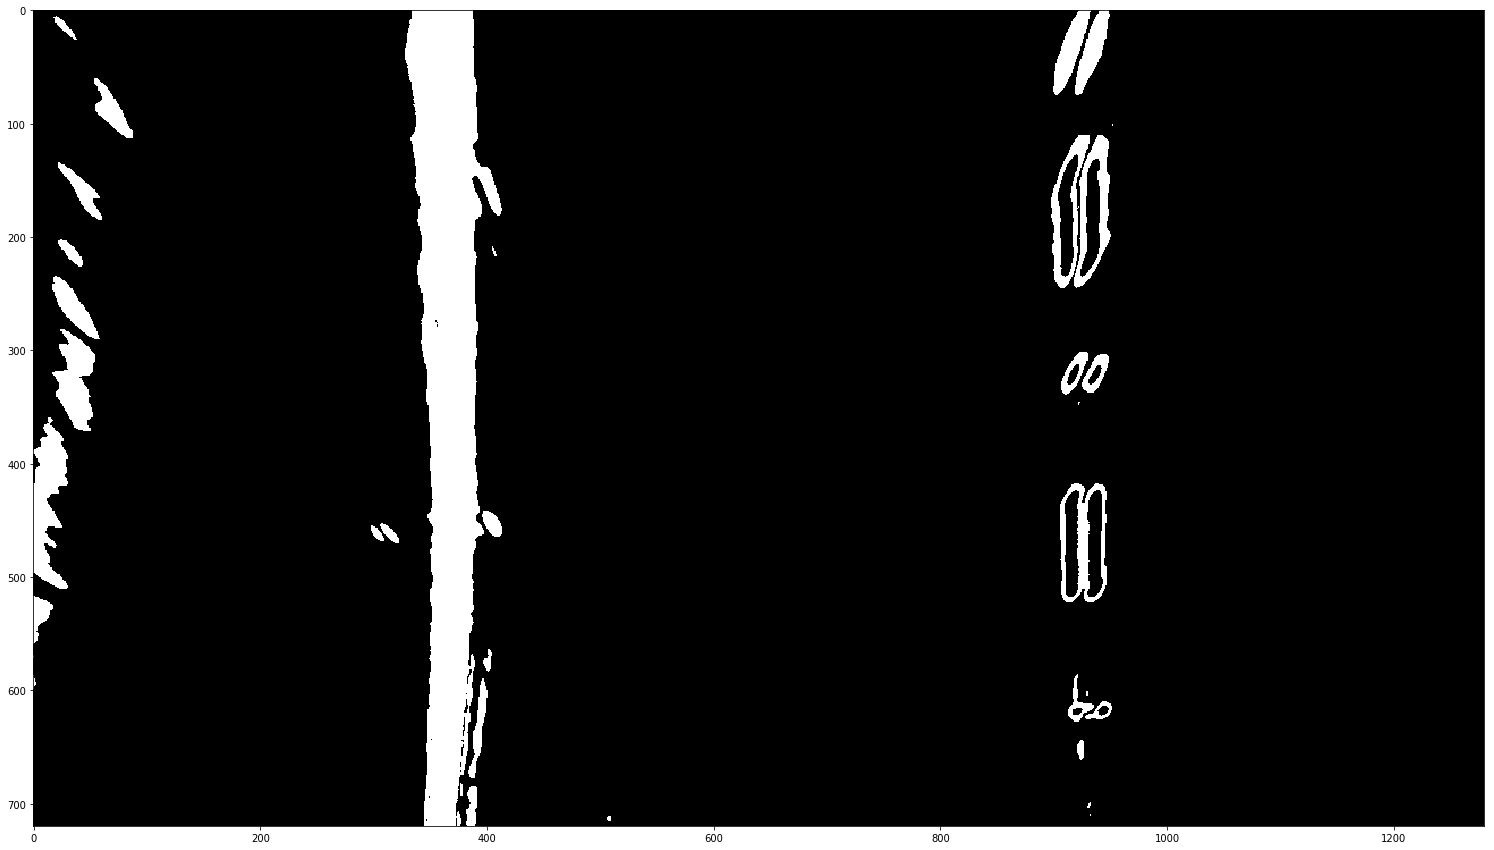

In [239]:
# s_thresh=(200, 255)
# sx_thresh=(19, 50)
#s_thresh=(25, 255), sx_thresh=(16, 255)
warped = preprocess_image(parallel, s_thresh=(80, 255), sx_thresh=(20, 100))

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(warped, cmap='gray')
plt.show()

In [245]:
def histogram_based_detect_lane(binary_warped):
    #fig = plt.figure(figsize=(26, 16)) 
    #plt.imshow(binary_warped, cmap='gray')
    #plt.show()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) or 0
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint or binary_warped.shape[0]

    print (histogram[50:600].shape)
    print(binary_warped.shape)
    print (leftx_base, midpoint, rightx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out_img, left_fit, right_fit
    
def findLanesWithPrevious(binary_warped, old_left_fit, old_right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = ((nonzerox > (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] - margin)) 
                      & (nonzerox < (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] - margin)) 
                       & (nonzerox < (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    #average between the old and new
    #if empty, fall back
    if (leftx.size == 0 or lefty.size == 0):
        left_fit= old_left_fit
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit = np.average( np.array([ old_left_fit, left_fit ]), axis=0, weights=[4, 1])
    if (rightx.size == 0 or righty.size == 0):
        right_fit = old_right_fit
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit = np.average( np.array([ old_right_fit, right_fit ]), axis=0, weights=[4, 1])
    
    #visualize
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    #draw the lane
    lane = np.hstack((left_line_window2, right_line_window1))
    cv2.fillPoly(window_img, np.int_([lane]), (200,0, 200))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #compute the radiuses of the lanes
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, str(left_curverad) + 'm, ' + str(right_curverad) + 'm', (10,result.shape[0] - 10), font, 1,(255,255,255),2)
    return result, left_fit, right_fit

(550,)
(720, 1280)
353 640 923


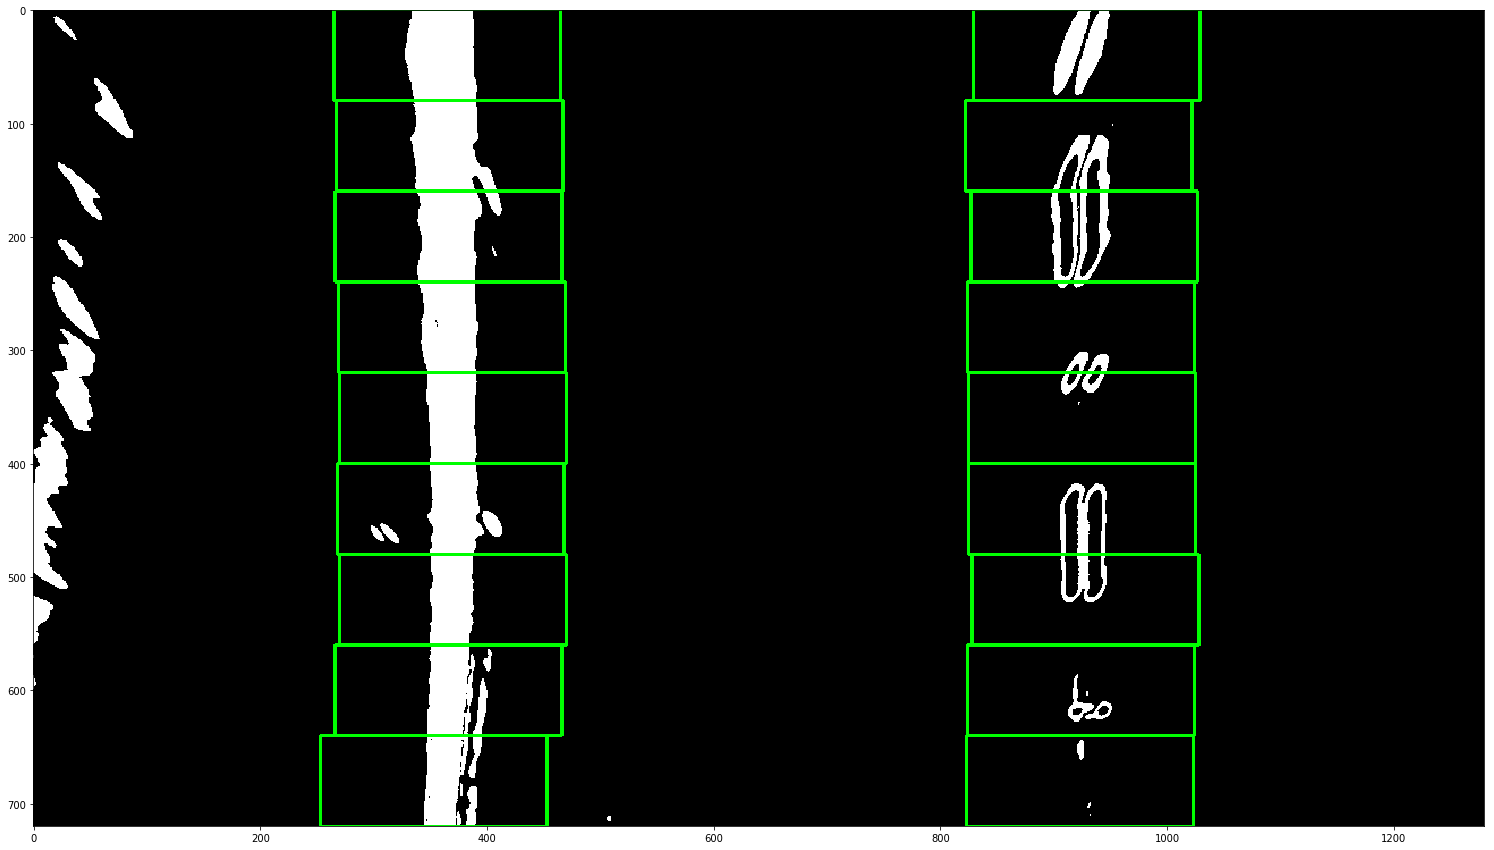

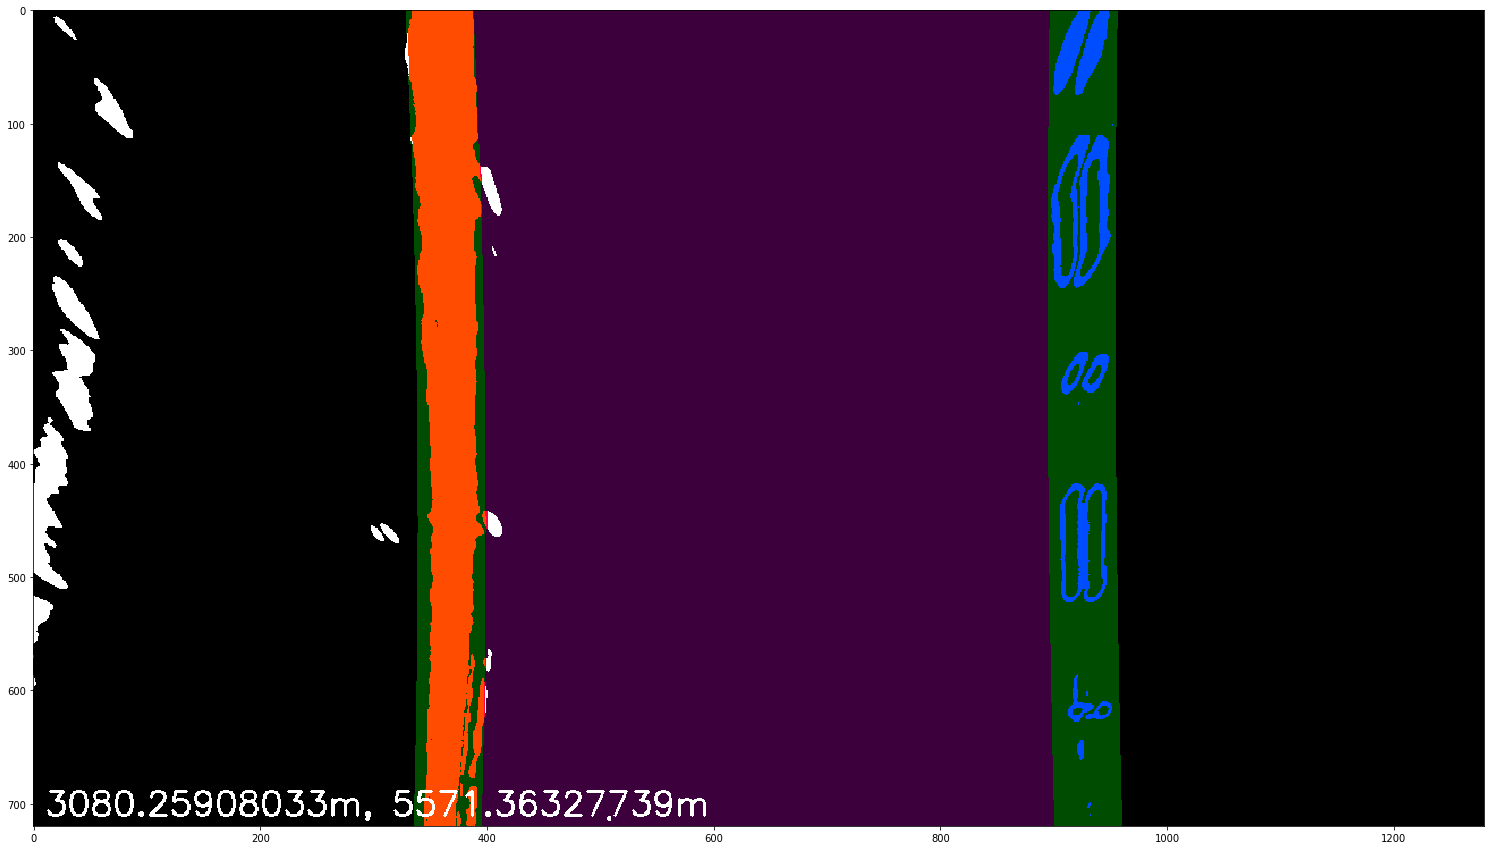

In [246]:
detected, l, r = histogram_based_detect_lane(warped)

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(detected)
plt.show()

redo, l, r  = findLanesWithPrevious(warped, l, r)
fig = plt.figure(figsize=(26, 16)) 
plt.imshow(redo)
plt.show()

In [242]:
l = None
r = None

import time

def pipeline(img):
    global l
    global r
    hls = correct_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    filename = "dump/" + str(time.time()) + ".jpg"
    cv2.imwrite(filename, hls)
    ready_to_process = make_paralel(preprocess_image(hls))
    if l is not None:
        detected, l, r = findLanesWithPrevious(ready_to_process, l, r)
    else:
        detected, l, r = histogram_based_detect_lane(ready_to_process)
    return detected

In [243]:
from moviepy.editor import VideoFileClip
white_output = 'white_notebook.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(lambda image:pipeline(image)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(550,)
(720, 1280)
405 640 974
[MoviePy] >>>> Building video white_notebook.mp4
[MoviePy] Writing video white_notebook.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:50,  7.41it/s]

  0%|          | 2/1261 [00:00<02:57,  7.09it/s]

  0%|          | 3/1261 [00:00<02:57,  7.09it/s]

  0%|          | 4/1261 [00:00<02:55,  7.16it/s]

  0%|          | 5/1261 [00:00<02:54,  7.22it/s]

  0%|          | 6/1261 [00:00<02:52,  7.26it/s]

  1%|          | 7/1261 [00:00<02:51,  7.32it/s]

  1%|          | 8/1261 [00:01<02:52,  7.28it/s]

  1%|          | 9/1261 [00:01<02:51,  7.31it/s]

  1%|          | 10/1261 [00:01<02:50,  7.33it/s]

  1%|          | 11/1261 [00:01<02:50,  7.34it/s]

  1%|          | 12/1261 [00:01<02:50,  7.34it/s]

  1%|          | 13/1261 [00:01<02:49,  7.35it/s]

  1%|          | 14/1261 [00:01<02:49,  7.36it/s]

  1%|          | 15/1261 [00:02<02:48,  7.38it/s]

  1%|▏         | 16/1261 [00:02<02:48,  7.41it/s]

  1%|▏         | 17/1261 [00:02<02:47,  7.42it/s]

  1%|▏         | 18/1261 [00:02<02:47,  7.41it/s]

  2%|▏         | 19/1261 [00:02<02:47,  7.41it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: white_notebook.mp4 

CPU times: user 4min 12s, sys: 2.33 s, total: 4min 14s
Wall time: 2min 55s


In [244]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))